In [2]:
import pandas as pd
import numpy as np
from station import Station
import seaborn as sns
import matplotlib.pyplot as plt
import mpld3
from fbprophet.diagnostics import cross_validation, performance_metrics

%load_ext autoreload
%autoreload

In [3]:
# read in data files
ride_df = pd.read_csv('data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')
map_df = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops.csv')
station_map_names = {'Lake':'Lake/State', 'Jackson':'Jackson/State',
                     'Washington':'Washington/Dearborn', 'Morgan':'Morgan-Lake'}
map_df.replace({"STATION_NAME": station_map_names}, inplace=True)

In [4]:
station_summary = pd.read_csv('data/station_summary.csv')

### Determine best locations for pie shop
Current high ridership would imply high-cost rent locations, which may not be affordable for the new local business. On the other hand, low ridership stations may not have enough pedestrian traffic that the new business may need to attract customers. Therefore, I chose train locations that have mean daily ridership within the middle range (25th to 80th percentile). 

In [7]:
# calculate change from 2018 to predicted ridership in 2023
station_summary['pctchange_2018_2023'] = ((
    station_summary['2023_predicted_mean']/station_summary['2018_mean'])-1)*100
station_summary['rawchange_2018_2023'] = (
    station_summary['2023_predicted_mean']-station_summary['2018_mean'])

# find stations with mid-range daily ridership & high anticipated growth
m_high = station_summary.quantile(.80).loc['2018_mean']
m_low = station_summary.quantile(.25).loc['2018_mean']

mid_means_2018 = station_summary[(station_summary['2018_mean'] < m_high) & (
    station_summary['2018_mean'] > m_low)]

midmean_highgrowth = mid_means_2018.sort_values(by=['pctchange_2018_2023'], 
                                                ascending=False).reset_index().loc[0:2]
station_summary['midmean_highgrowth']=0
station_summary.loc[midmean_highgrowth['index'],'midmean_highgrowth']=1


In [8]:
# plot scatterplot: mean 2018 ridership vs. anticipated growth
# highlight stations selected for pie shop (mid-range mean high-growth stations)

df=station_summary[station_summary['2023_predicted_mean']>0]
x='2018_mean'
y='pctchange_2018_2023'
color = 'midmean_highgrowth'
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))

scatter = ax.scatter(np.array(df[x], dtype=float),
                     np.array(df[y], dtype=float),
                     c=np.array(df[color], dtype=float),
                     alpha=0.9,
                     vmin=0,
                     vmax=6,
                     cmap='Set2')


ax.grid(color='white', linestyle='solid')

ax.set_title(x+' vs '+y, size=20)
ax.set_xlabel('2018 Mean Daily Rides', fontsize=16)
ax.set_ylabel('Projected % Growth 2018-2023', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

labels = df['station'].tolist()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()


## Forecasting future growth
With our selected midmean_highgrowth stations, use fbprophet forecast model to ask which of these has high potential for growth in the the next 5 years. 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2013-07-26 00:00:00 and 2018-01-01 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-01-12 00:00:00 and 2018-01-01 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 33 forecasts with cutoffs between 2002-03-26 00:00:00 and 2018-01-01 00:00:00
/Users/djb326/.pyenv/versions/3.6.7/lib/python3.6/site-packages/fbprophet/diagnostics.py:257: RuntimeWarning: invalid value encountered in subtract
  return np.hstack((prefix, (s[w:] - s[:-w]) / float(w)))  # right-aligned


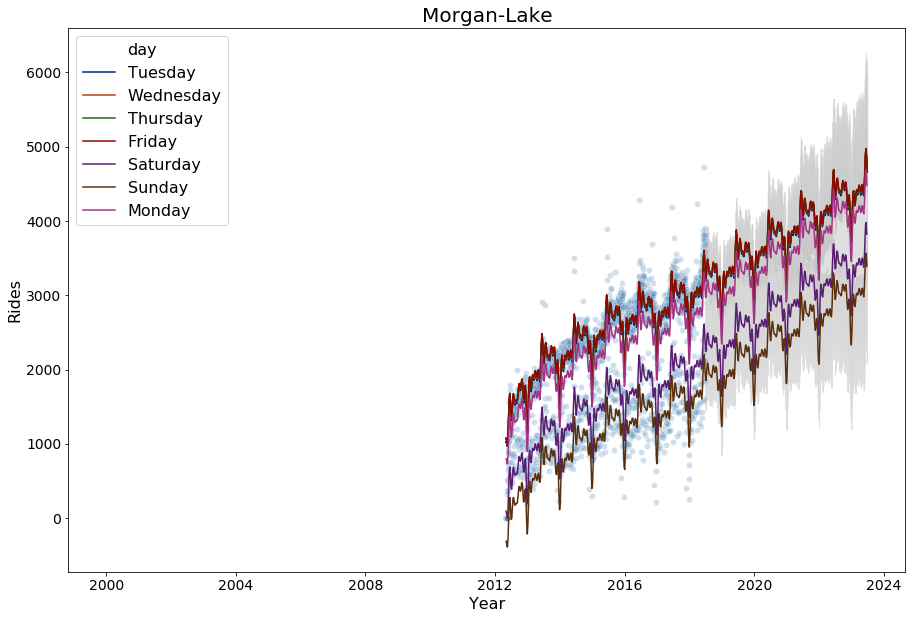

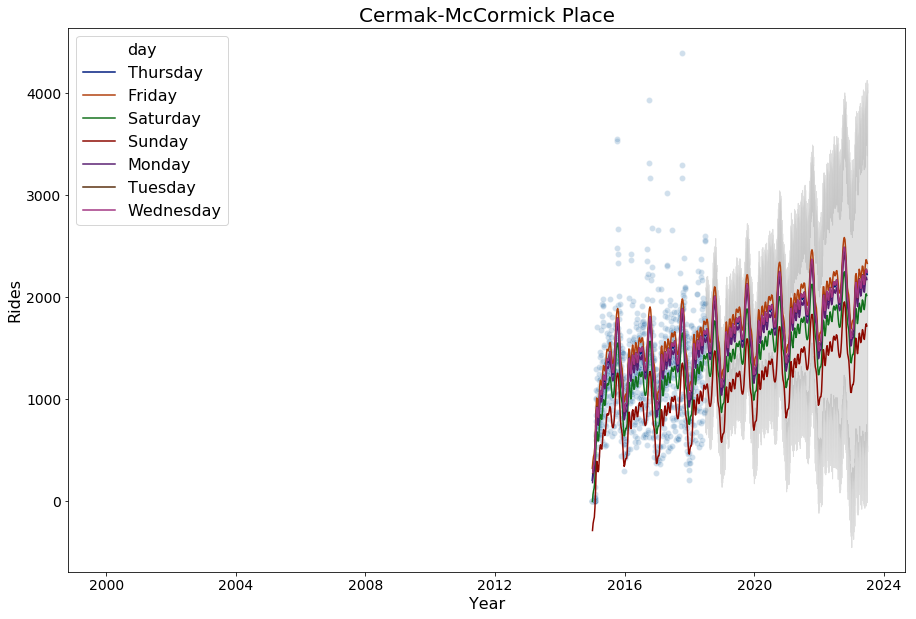

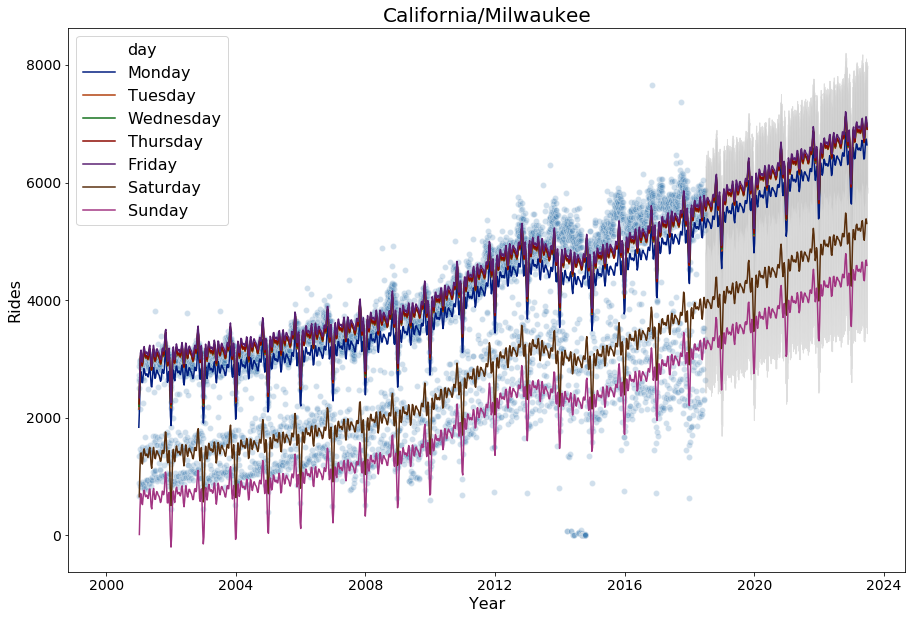

In [11]:
pie_stations = midmean_highgrowth.station.tolist()
station_class = []

# # rerun Station class on pie stations & make projection figs
for pie in pie_stations:
    stat = Station(pie, ride_df, map_df)
    stat.run_prophet()
    stat.run_prophet_diagnostics()
    station_class.append(stat)
    
    
    stat.preprocessed['day']=stat.preprocessed.index.weekday_name
    stat.forecast_all['day']=pd.DatetimeIndex(stat.forecast_all['ds']).weekday_name
    future = stat.forecast_all[stat.forecast_all['ds']>pd.to_datetime('06-30-2018')]
   
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(x='datetime', y='rides', 
                    data=stat.preprocessed.reset_index(), alpha=.25, color='steelblue', ax=ax)
    sns.lineplot(x='ds', y='yhat',hue='day', data=stat.forecast_all, palette='dark', ax=ax)
    ax.fill_between(np.array(future['ds']), np.array(future['yhat_lower']), 
                    np.array(future['yhat_upper']), color='grey', alpha=.25)
    plt.title(stat.name, fontsize=20)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlabel('Year', fontsize=16)
    ax.set_ylabel('Rides', fontsize=16)
    plt.legend(loc='upper left', fontsize=16)
    fname = stat.name + '_growth.png'
    fname = fname.replace('/','_')
    plt.savefig('figs/' + fname)

/Users/djb326/.pyenv/versions/3.6.7/lib/python3.6/site-packages/fbprophet/diagnostics.py:257: RuntimeWarning: invalid value encountered in subtract
  return np.hstack((prefix, (s[w:] - s[:-w]) / float(w)))  # right-aligned


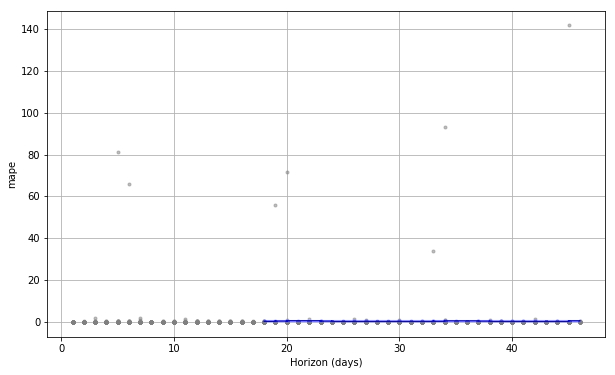

In [19]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(station_class[2].cv, metric='mape')